In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
DF = pd.read_csv('covid19.csv')
COUNTRY = 'Ireland'
START_DATE, END_DATE, TEST_DATE = '2020-03-10', '2020-05-10', '2020-07-10'

formulas for interpolating

In [3]:
F = lambda x, a, b: 1 - np.exp(-(a*x)**b)
Fc = lambda x, a, b: np.exp(-x**1.15+a)**b
get_cantegi = lambda x: np.array([x[i+1]/x[i] - 1 for i in np.arange(len(x)-1)]+[0])

def get_other(F, y, a_this, b_this, a_other, b_other):
    x = ((-np.log(1-y))**(1/b_this))/a_this
    return F(x, a_other, b_other)

# Traning

In [4]:
df_train = DF[(DF['Country'] == COUNTRY) & (DF['Date'] >= START_DATE) & (DF['Date'] <= END_DATE)]
confirmed_train = df_train['Confirmed'].to_numpy()
deaths_train = df_train['Deaths'].to_numpy()
cantegi_train = get_cantegi(confirmed_train)
range_train = np.arange(len(df_train))

In [5]:
confirmed_vals, _ = curve_fit(F, range_train, confirmed_train/confirmed_train[-1])
deaths_vals, _ = curve_fit(F, range_train, deaths_train/deaths_train[-1])
cantegi_vals, _ = curve_fit(Fc, range_train, cantegi_train)

In [6]:
c = deaths_train[-1]/confirmed_train[-1]
oracle_deaths = (confirmed_train[-1]*c)*get_other(F, confirmed_train/confirmed_train[-1], *confirmed_vals, *deaths_vals)

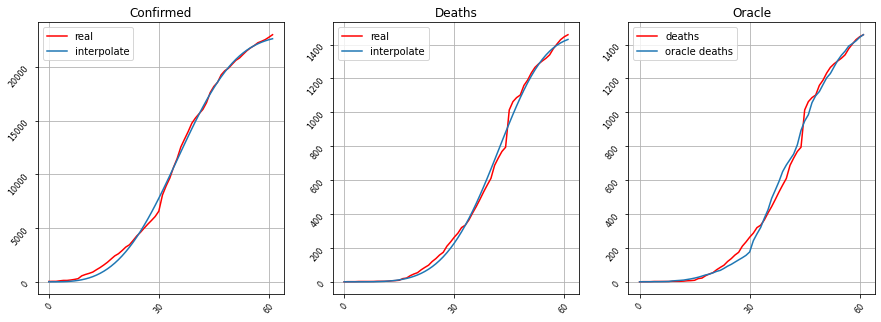

Confirmed bug: 0.029168236765023628
Deaths bug: 0.053806644884584864
Oracle bug: 0.06821930716655189


In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(range_train, confirmed_train, label='real', color='red')
ax1.plot(range_train, confirmed_train[-1]*F(range_train, *confirmed_vals), label='interpolate')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax1.tick_params(labelsize=8, labelrotation=50)
ax1.grid()
ax1.set_title('Confirmed')
ax1.legend()

ax2.plot(range_train, deaths_train, label='real', color='red')
ax2.plot(range_train, deaths_train[-1]*F(range_train, *deaths_vals), label='interpolate')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax2.tick_params(labelsize=8, labelrotation=50)
ax2.grid()
ax2.set_title('Deaths')
ax2.legend()

oracle_deaths = (confirmed_train[-1]*c)*get_other(F, confirmed_train/confirmed_train[-1], *confirmed_vals, *deaths_vals)
ax3.plot(range_train, deaths_train, label='deaths', color='red')
ax3.plot(range_train, oracle_deaths, label='oracle deaths')
ax3.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax3.tick_params(labelsize=8, labelrotation=50)
ax3.grid()
ax3.set_title('Oracle')
ax3.legend()
plt.show()

print('Confirmed bug:', max(confirmed_train/confirmed_train[-1] - F(range_train, *confirmed_vals)))
print('Deaths bug:', max(deaths_train/deaths_train[-1] - F(range_train, *deaths_vals)))
print('Oracle bug:', max((oracle_deaths - deaths_train)/deaths_train[-1]))

# Testing

In [8]:
df_test = DF[(DF['Country'] == COUNTRY) & (DF['Date'] >= START_DATE) & (DF['Date'] <= TEST_DATE)]
confirmed_test = df_test['Confirmed'].to_numpy()
deaths_test = df_test['Deaths'].to_numpy()
cantegi_test = get_cantegi(confirmed_test)
range_test = np.arange(len(df_test))

In [9]:
cantegi_oracle = Fc(range_test, *cantegi_vals)
oracle = [confirmed_train[-1]]
for i in range(len(range_train), len(range_test)):
    oracle.append((Fc(i, *cantegi_vals)+1) * oracle[-1])
oracle_confirmed = np.concatenate((confirmed_train[:-1], np.array(oracle)))

### check cantegi

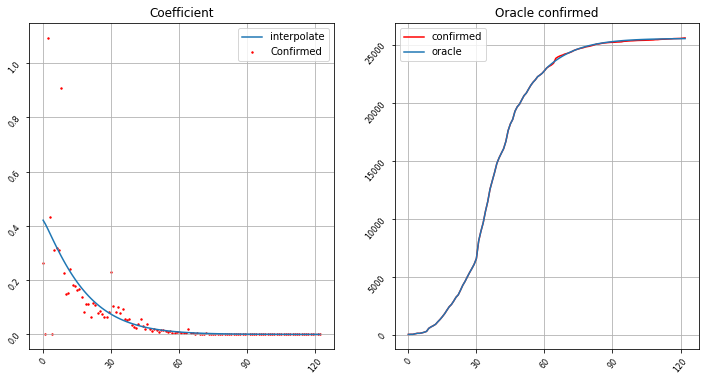

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(range_test, cantegi_test, label='Confirmed', s=2, color='red')
ax1.plot(range_test, cantegi_oracle, label='interpolate')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax1.tick_params(labelsize=8, labelrotation=50)
ax1.grid()
ax1.set_title('Coefficient')
ax1.legend()

ax2.plot(range_test, confirmed_test, label='confirmed', color='red')
ax2.plot(range_test, oracle_confirmed,  label='oracle')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax2.tick_params(labelsize=8, labelrotation=50)
ax2.grid()
ax2.set_title('Oracle confirmed')
ax2.legend()
plt.show()

### check oracle

Oracle bug: 0.07258325964523023


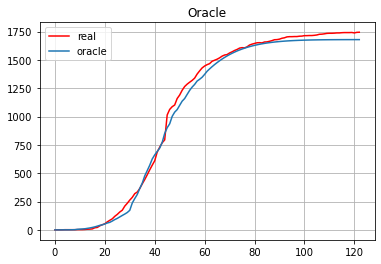

In [17]:
oracle_deaths = (c*(confirmed_test[-1]/confirmed_train[-1])*0.93)*confirmed_test[-1]*get_other(F, oracle_confirmed/oracle_confirmed[-1], *confirmed_vals, *deaths_vals)

plt.plot(range_test, deaths_test, label='real', color='red')
plt.plot(range_test, oracle_deaths,  label='oracle')
plt.grid()
plt.title('Oracle')
plt.legend()
plt.savefig('res.png')
plt.show()
print('Oracle bug:', max((deaths_test-oracle_deaths)/1750))